## 11. Adaptive radial map stochastic map filter for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [4]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been

In [5]:
using DelimitedFiles

Load some packages to make nice figures

In [6]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# pyplot()

using LaTeXStrings
# PyPlot.rc("text", usetex = "true")
# PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [7]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [8]:
Δtdyn = 0.05
Δtobs = 0.4

0.4

Define the time span of interest

In [9]:
t0 = 0.0
tf = 4000.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

10000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [10]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [11]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

Define the additive inflation for the dynamical and observation models

In [12]:
### Process and observation noise
σx = 1e-6
σy = 2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0])

In [13]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\{\boldsymbol{x}^i\}$ are i.i.d. samples from pushforward of the standard Gaussian distribution by the flow of the Lorenz-63 system.

In [14]:
# Time span
tspan = (0.0, tf)

(0.0, 4000.0)

Set initial condition of the true system

In [15]:
x0 = rand(model.π0);

In [16]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [85]:
# Ensemble size
Ne = 160

X0 = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X0, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×160 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
 0.0354621   0.136571  -0.871434  1.01892   …  -1.43778   0.951514   0.884698
 2.01645    -1.04806   -1.81428   0.982215     -0.735873  1.48505    0.731567
 0.679222   -0.111855  -1.03683   1.40604       0.501236  1.15227   -1.0118

Use the stochastic ensemble Kalman filter for the spin-up phase. There is no reason to use the stochastic map filter over the first cycles, as the performance of the inference is determined by the quality of the ensemble, not the quality of the filter.

In [86]:
enkf = StochEnKF(x->x, ϵy, Δtdyn, Δtobs)

Stochastic EnKF  with filtered = false


In [87]:
Xenkf = seqassim(F, data, Tf, model.ϵx, enkf, deepcopy(X0), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


In [88]:
tspin = 1000.0
Tspin = ceil(Int64, (tspin-t0)/Δtobs)

2500

Time average root-mean-squared error 

In [89]:
rmse_enkf = mean(map(i->norm(data.xt[:,i]-mean(Xenkf[i+1]; dims = 2))/sqrt(Nx), Tspin:Tf))

1.0692108281291755

Initialize the ensemble matrix for the radial stochastic map filter

In [90]:
Xspin = vcat(zeros(Ny, Ne), deepcopy(Xenkf[Tspin+1]))
observe(h, Xspin, tspin, Ny, Nx)
ϵy(Xspin, 1, Ny)
Xspin

6×160 Array{Float64,2}:
  3.73146   2.25102   0.146145   2.8297   …  -1.54753   2.89072   0.13446
 13.3375    4.81129   4.48228    8.96264      5.72853   6.96139   4.7746
 27.9605   24.4606   28.8487    29.6017      31.6143   28.166    26.3447
  2.48973   1.60691   0.613738   2.94037      1.18162   1.04032   1.26939
  7.63341   5.91787   6.50447    8.4262       6.16331   6.97294   6.29414
 28.3593   26.57     28.6678    28.0938   …  27.3332   28.3656   27.4226

In [91]:
tsmf = 4000.0
Tsmf = ceil(Int64, (tsmf-tspin)/Δtobs)

7500

Initialize the structure of the map

In [92]:
p = 2
# order = [[-1], [p; p], [-1; p; 0], [-1; p; p; 0]]
order = [[-1], [p; p], [-1; p; 0], [-1; p; p; 0]]

# order = [[-1], [-1; -1], [-1; -1; -1], [p; -1; -1 ;p], [-1; p; -1; p; p], [-1; -1; p; p; p; p]]

# parameters of the radial map
γ = 2.0
λ = 0.0
δ = 1e-8
κ = 10.0
β = 1.0

dist = Float64.(metric_lorenz(3))
idx = vcat(collect(1:Ny)',collect(1:Ny)')

smf = SparseRadialSMF(x->x, F.h, β, ϵy, order, γ, λ, δ, κ, 
                      Ny, Nx, Ne, 
                      Δtdyn, Δtobs, 
                      dist, idx; islocalized = true)

SparseRadialSMF(var"#47#48"(), h, 1.0, AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0]), Sparse Radial Map of dimension Nx = 4 and order p = [[-1], [2, 2], [-1, 2, 0], [-1, 2, 2, 0]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.0, 1.0e-8, 10.0)
, 3, 3, 0.05, 0.4, [0.0 1.0 1.0; 1.0 0.0 1.0; 1.0 1.0 0.0], [1 2 3; 1 2 3], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], false, true, false)

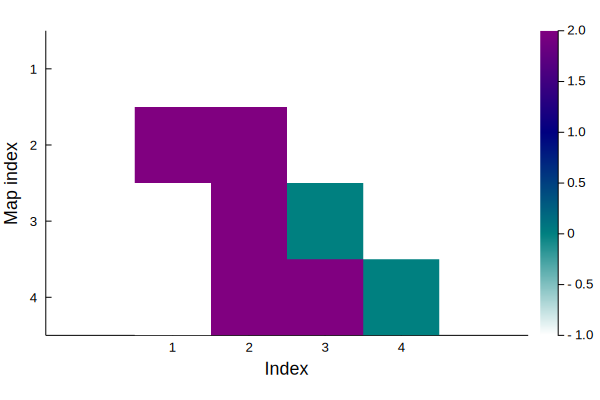

In [93]:
plot(smf.S)

In [133]:
Xtest = vcat(Xspin[1:1,:], Xspin[Ny+1:Ny+Nx,:])

4×160 Array{Float64,2}:
  3.73146   2.25102   0.146145   2.8297   …  -1.54753   2.89072   0.13446
  2.48973   1.60691   0.613738   2.94037      1.18162   1.04032   1.26939
  7.63341   5.91787   6.50447    8.4262       6.16331   6.97294   6.29414
 28.3593   26.57     28.6678    28.0938      27.3332   28.3656   27.4226

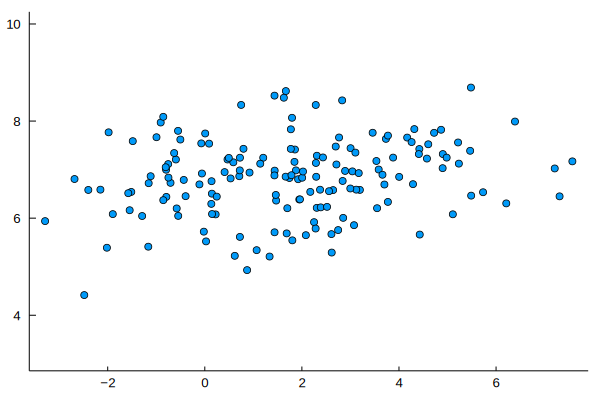

In [134]:
scatter(Xtest[1,:], Xtest[3,:], ratio = 1, legend =false)

In [135]:
@show norm(Xtest)
Sgreedy = SparseRadialMap(Xtest, -1; λ = λ, δ = δ, γ = γ)
@show norm(Xtest)

norm(Xtest) = 369.521382949262
norm(Xtest) = 369.521382949262


369.521382949262

In [136]:
Sgreedy.L.L.diag - std(Xtest; dims = 2)[:,1]

4-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0

In [137]:
@show norm(Xtest)
optimize(Sgreedy, Xtest, poff, [2;0;0], "kfolds";
         apply_rescaling = true, start = 2)
@show norm(Xtest)

norm(Xtest) = 369.521382949262
norm(Xtest) = 369.521382949262


369.521382949262

In [143]:
# @show norm(Xtest)
Sx = deepcopy(Sgreedy(Xtest; apply_rescaling = true, start = 2))
# @show norm(Xtest)

4×160 Array{Float64,2}:
 0.0        0.0         0.0       …   0.0        0.0        0.0
 0.652964  -0.0437932  -0.613008      0.422594  -0.661838  -0.0289272
 0.560931  -1.55653     0.251328     -0.751911   0.794188  -0.591014
 0.238918   0.0358865   0.300059     -0.287845  -1.17738   -0.160135

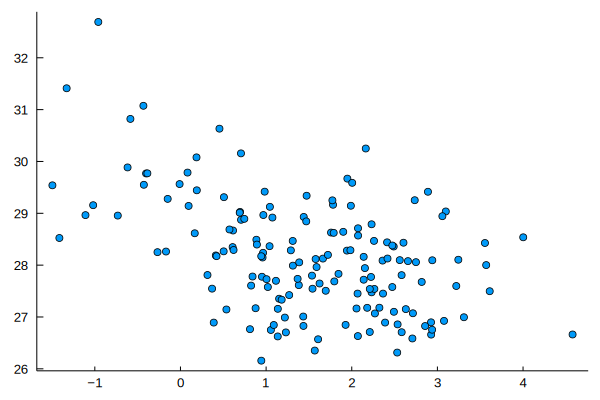

In [164]:
scatter(Xtest[2,:], Xtest[4,:], legend = false)

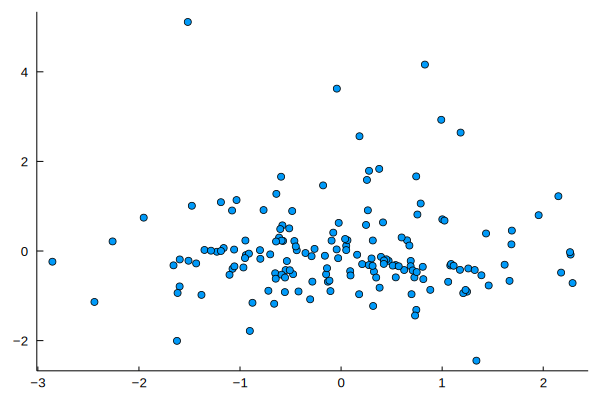

In [162]:
scatter(Sx[2,:], Sx[4,:], legend = false)

In [145]:
ystar = [2.5]

1-element Array{Float64,1}:
 2.5

In [147]:
Xpost = deepcopy(Xtest)
inverse!(Xpost, Sx, Sgreedy, ystar; apply_rescaling = true)

4×160 Array{Float64,2}:
  2.5       2.5       2.5       2.5      …   2.5       2.5        2.5
  2.30615   1.64082   1.03208   2.90094      2.09477   0.977233   1.6559
  7.51691   5.93585   6.66358   8.39992      6.6474    6.9467     6.48795
 28.3552   26.5571   28.4013   28.0966      26.9856   28.3938    27.26

In [158]:
norm(Sgreedy(vcat(ystar[1]*ones(1, Ne), Xpost[2:4,:]))[2:4,:]-Sx[2:4,:])

3.995739747257177e-14

In [124]:
poff = 2
pdiag = 0

γ = 2.0
λ = 0.0
δ = 1e-8
κ = 10.0
β = 1.0

dist = Float64.(metric_lorenz(3))
idx = vcat(collect(1:Ny)',collect(1:Ny)')

# Sgreedy = SparseRadialMap(Nx+1, -1; λ = λ, δ = δ, γ = γ)
Sgreedy = SparseRadialMap(vcat(Xspin[1:1,:], Xspin[Ny+1:Ny+Nx,:]), -1; λ = λ, δ = δ, γ = γ)
optimize(Sgreedy, vcat(Xspin[1:1,:], Xspin[Ny+1:Ny+Nx,:]), poff, [2;0;0], "kfolds";
         apply_rescaling = true, start = 2)

smf_greedy = SparseRadialSMF(x->x, F.h, β, ϵy, Sgreedy,
                      Ny, Nx, 
                      Δtdyn, Δtobs,
                      dist, idx, zeros(Nx+1, Ne), false, true, true)

SparseRadialSMF(var"#51#52"(), h, 1.0, AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0]), Sparse Radial Map of dimension Nx = 4 and order p = [[-1], [2, 2], [-1, 2, 0], [2, 2, 2, 0]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.0, 1.0e-8, 10.0)
, 3, 3, 0.05, 0.4, [0.0 1.0 1.0; 1.0 0.0 1.0; 1.0 1.0 0.0], [1 2 3; 1 2 3], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], false, true, true)

In [125]:
Sgreedy

Sparse Radial Map of dimension Nx = 4 and order p = [[-1], [2, 2], [-1, 2, 0], [2, 2, 2, 0]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.0, 1.0e-8, 10.0)


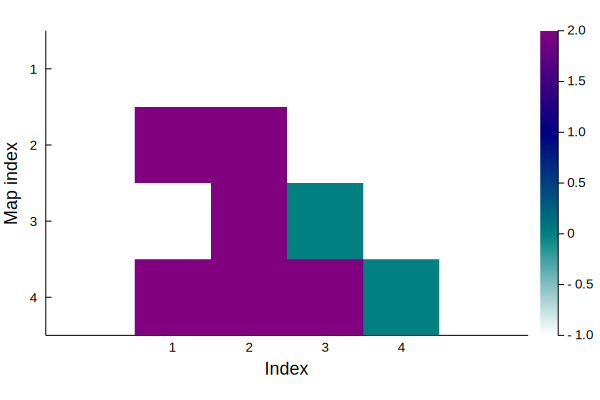

In [126]:
plot(smf_greedy.S)

In [127]:
smf_greedy.S[4].coeff

4-element Array{Array{Float64,1},1}:
 [0.02588550351868009, 1.0995954895399032, 1.2005781185290185]
 [3.7971829352525504, 6.797638803781895, -0.7406096867740734]
 [-2.9310135592482416, 9.836049865394765, -6.834532910540491]
 [-2.171659253537387, 3.0672808161999336]

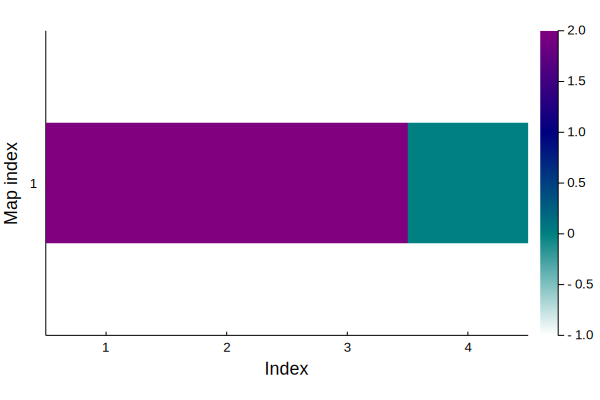

In [128]:
plot(smf_greedy.S[4])

In [60]:
Xsmf = seqassim(F, data, Tsmf, model.ϵx, smf, deepcopy(Xspin), model.Ny, model.Nx, tspin);

Progress:   0%|                                         |  ETA: 0:22:37

norm(smf.S.L.μ) = 8.044670581079728
norm(smf.S.L.μ) = 35.38135071346596
norm(smf.S.L.μ) = 35.38135071346596
norm(smf.S.L.μ) = 4.175298974357152
norm(smf.S.L.μ) = 4.175298974357152
norm(smf.S.L.μ) = 13.509857552288905
norm(smf.S.L.μ) = 13.509857552288905
norm(smf.S.L.μ) = 30.897907169844327
norm(smf.S.L.μ) = 30.897907169844327
norm(smf.S.L.μ) = 6.9932490384142705
norm(smf.S.L.μ) = 6.9932490384142705
norm(smf.S.L.μ) = 6.281848432137389
norm(smf.S.L.μ) = 6.281848432137389
norm(smf.S.L.μ) = 42.141318508804716
norm(smf.S.L.μ) = 42.141318508804716
norm(smf.S.L.μ) = 6.118197231427343
norm(smf.S.L.μ) = 6.118197231427343
norm(smf.S.L.μ) = 7.403565045649935
norm(smf.S.L.μ) = 7.403565045649935
norm(smf.S.L.μ) = 38.57290701419695
norm(smf.S.L.μ) = 38.57290701419695
norm(smf.S.L.μ) = 23.377587588277663
norm(smf.S.L.μ) = 23.377587588277663
norm(smf.S.L.μ) = 15.83047498690729
norm(smf.S.L.μ) = 15.83047498690729
norm(smf.S.L.μ) = 36.9463758889861
norm(smf.S.L.μ) = 36.9463758889861
norm(smf.S.L.μ) = 9.

Progress:   0%|▏                                        |  ETA: 0:03:26

norm(smf.S.L.μ) = 45.08561515590955
norm(smf.S.L.μ) = 9.070797073328748
norm(smf.S.L.μ) = 9.070797073328748
norm(smf.S.L.μ) = 4.682846703849439
norm(smf.S.L.μ) = 4.682846703849439
norm(smf.S.L.μ) = 28.256895015221996
norm(smf.S.L.μ) = 28.256895015221996
norm(smf.S.L.μ) = 6.171394555488416
norm(smf.S.L.μ) = 6.171394555488416
norm(smf.S.L.μ) = 4.267564808069482
norm(smf.S.L.μ) = 4.267564808069482
norm(smf.S.L.μ) = 34.22461568373733
norm(smf.S.L.μ) = 34.22461568373733
norm(smf.S.L.μ) = 1.3177506199291062
norm(smf.S.L.μ) = 1.3177506199291062
norm(smf.S.L.μ) = 0.15583620219986624
norm(smf.S.L.μ) = 0.15583620219986624
norm(smf.S.L.μ) = 31.15009465920747
norm(smf.S.L.μ) = 31.15009465920747
norm(smf.S.L.μ) = 29.70070323462755
norm(smf.S.L.μ) = 29.70070323462755
norm(smf.S.L.μ) = 13.991021382923142
norm(smf.S.L.μ) = 13.991021382923142
norm(smf.S.L.μ) = 26.385895945092823
norm(smf.S.L.μ) = 26.385895945092823
norm(smf.S.L.μ) = 1.0914726152981997
norm(smf.S.L.μ) = 1.0914726152981997
norm(smf.S.L.μ

Progress:   0%|▏                                        |  ETA: 0:02:22

norm(smf.S.L.μ) = 0.26550988888028015
norm(smf.S.L.μ) = 33.06934847381356
norm(smf.S.L.μ) = 33.06934847381356
norm(smf.S.L.μ) = 4.197969374470692
norm(smf.S.L.μ) = 4.197969374470692
norm(smf.S.L.μ) = 1.9921093407971495
norm(smf.S.L.μ) = 1.9921093407971495
norm(smf.S.L.μ) = 34.49695253399988
norm(smf.S.L.μ) = 34.49695253399988
norm(smf.S.L.μ) = 5.656950237122571
norm(smf.S.L.μ) = 5.656950237122571
norm(smf.S.L.μ) = 0.08239561697762599
norm(smf.S.L.μ) = 0.08239561697762599
norm(smf.S.L.μ) = 34.22553771746505
norm(smf.S.L.μ) = 34.22553771746505
norm(smf.S.L.μ) = 1.2589958177104785
norm(smf.S.L.μ) = 1.2589958177104785
norm(smf.S.L.μ) = 24.575281613501076
norm(smf.S.L.μ) = 24.575281613501076
norm(smf.S.L.μ) = 21.37372995147265
norm(smf.S.L.μ) = 21.37372995147265
norm(smf.S.L.μ) = 0.3715970599555538
norm(smf.S.L.μ) = 0.3715970599555538
norm(smf.S.L.μ) = 0.4458314620930319
norm(smf.S.L.μ) = 0.4458314620930319
norm(smf.S.L.μ) = 22.202235260833046
norm(smf.S.L.μ) = 22.202235260833046
norm(smf.S

Progress:   1%|▎                                        |  ETA: 0:02:00

norm(smf.S.L.μ) = 31.33375567761789
norm(smf.S.L.μ) = 14.828429405181472
norm(smf.S.L.μ) = 14.828429405181472
norm(smf.S.L.μ) = 25.848589569040303
norm(smf.S.L.μ) = 25.848589569040303
norm(smf.S.L.μ) = 40.30211272121254
norm(smf.S.L.μ) = 40.30211272121254
norm(smf.S.L.μ) = 0.6230600585273792
norm(smf.S.L.μ) = 0.6230600585273792
norm(smf.S.L.μ) = 1.5179537130261946
norm(smf.S.L.μ) = 1.5179537130261946
norm(smf.S.L.μ) = 37.13747894858536
norm(smf.S.L.μ) = 37.13747894858536
norm(smf.S.L.μ) = 12.615196361109657
norm(smf.S.L.μ) = 12.615196361109657
norm(smf.S.L.μ) = 13.169966625474231
norm(smf.S.L.μ) = 13.169966625474231
norm(smf.S.L.μ) = 28.578332081729492
norm(smf.S.L.μ) = 28.578332081729492
norm(smf.S.L.μ) = 0.3821310031418797
norm(smf.S.L.μ) = 0.3821310031418797
norm(smf.S.L.μ) = 0.6843265908513425
norm(smf.S.L.μ) = 0.6843265908513425
norm(smf.S.L.μ) = 21.471531814909206
norm(smf.S.L.μ) = 21.471531814909206
norm(smf.S.L.μ) = 17.01438755429666
norm(smf.S.L.μ) = 17.01438755429666
norm(smf

Progress:   1%|▎                                        |  ETA: 0:01:47

norm(smf.S.L.μ) = 66.55136247421696
norm(smf.S.L.μ) = 31.18897400839595
norm(smf.S.L.μ) = 31.18897400839595
norm(smf.S.L.μ) = 0.33746594532098845
norm(smf.S.L.μ) = 0.33746594532098845
norm(smf.S.L.μ) = 6.2362066221672965
norm(smf.S.L.μ) = 6.2362066221672965
norm(smf.S.L.μ) = 22.801215000820868
norm(smf.S.L.μ) = 22.801215000820868
norm(smf.S.L.μ) = 3.973545708688027
norm(smf.S.L.μ) = 3.973545708688027
norm(smf.S.L.μ) = 0.7762519336946575
norm(smf.S.L.μ) = 0.7762519336946575
norm(smf.S.L.μ) = 42.653862031481424
norm(smf.S.L.μ) = 42.653862031481424
norm(smf.S.L.μ) = 15.112291766916112
norm(smf.S.L.μ) = 15.112291766916112
norm(smf.S.L.μ) = 1.3760658755365862
norm(smf.S.L.μ) = 1.3760658755365862
norm(smf.S.L.μ) = 35.11710820426118
norm(smf.S.L.μ) = 35.11710820426118
norm(smf.S.L.μ) = 1.0037223327295142
norm(smf.S.L.μ) = 1.0037223327295142
norm(smf.S.L.μ) = 3.981641155109697
norm(smf.S.L.μ) = 3.981641155109697
norm(smf.S.L.μ) = 25.072944692416318
norm(smf.S.L.μ) = 25.072944692416318
norm(smf

Progress:   1%|▍                                        |  ETA: 0:01:39

norm(smf.S.L.μ) = 2.2594523689501145
norm(smf.S.L.μ) = 26.69742762624862
norm(smf.S.L.μ) = 26.69742762624862
norm(smf.S.L.μ) = 10.00374624120384
norm(smf.S.L.μ) = 10.00374624120384
norm(smf.S.L.μ) = 1.3145718237674318
norm(smf.S.L.μ) = 1.3145718237674318
norm(smf.S.L.μ) = 36.8158746337295
norm(smf.S.L.μ) = 36.8158746337295
norm(smf.S.L.μ) = 16.06467420305554
norm(smf.S.L.μ) = 16.06467420305554
norm(smf.S.L.μ) = 10.03327019094572
norm(smf.S.L.μ) = 10.03327019094572
norm(smf.S.L.μ) = 42.27952796880743
norm(smf.S.L.μ) = 42.27952796880743
norm(smf.S.L.μ) = 7.456476201167073
norm(smf.S.L.μ) = 7.456476201167073
norm(smf.S.L.μ) = 0.3294547636485943
norm(smf.S.L.μ) = 0.3294547636485943
norm(smf.S.L.μ) = 42.48333584037895
norm(smf.S.L.μ) = 42.48333584037895
norm(smf.S.L.μ) = 9.43356883032475
norm(smf.S.L.μ) = 9.43356883032475
norm(smf.S.L.μ) = 17.57670738000214
norm(smf.S.L.μ) = 17.57670738000214
norm(smf.S.L.μ) = 26.58428718436392
norm(smf.S.L.μ) = 26.58428718436392
norm(smf.S.L.μ) = 0.4107481

Progress:   1%|▍                                        |  ETA: 0:01:32

norm(smf.S.L.μ) = 1.5350186918959505
norm(smf.S.L.μ) = 40.597231147083335
norm(smf.S.L.μ) = 40.597231147083335
norm(smf.S.L.μ) = 34.794632585505454
norm(smf.S.L.μ) = 34.794632585505454
norm(smf.S.L.μ) = 0.7270928704195253
norm(smf.S.L.μ) = 0.7270928704195253
norm(smf.S.L.μ) = 2.1710798505520197
norm(smf.S.L.μ) = 2.1710798505520197
norm(smf.S.L.μ) = 42.60659193281926
norm(smf.S.L.μ) = 42.60659193281926
norm(smf.S.L.μ) = 9.240106411162923
norm(smf.S.L.μ) = 9.240106411162923
norm(smf.S.L.μ) = 17.262677137806712
norm(smf.S.L.μ) = 17.262677137806712
norm(smf.S.L.μ) = 27.929975981150925
norm(smf.S.L.μ) = 27.929975981150925
norm(smf.S.L.μ) = 1.2366078628025028
norm(smf.S.L.μ) = 1.2366078628025028
norm(smf.S.L.μ) = 0.8041548747561886
norm(smf.S.L.μ) = 0.8041548747561886
norm(smf.S.L.μ) = 24.181482198682076
norm(smf.S.L.μ) = 24.181482198682076
norm(smf.S.L.μ) = 10.268620083697689
norm(smf.S.L.μ) = 10.268620083697689
norm(smf.S.L.μ) = 26.908528466104094
norm(smf.S.L.μ) = 26.908528466104094
norm(

Progress:   1%|▌                                        |  ETA: 0:01:29

norm(smf.S.L.μ) = 0.16044151702225587
norm(smf.S.L.μ) = 37.58825371530705
norm(smf.S.L.μ) = 37.58825371530705
norm(smf.S.L.μ) = 2.2053642246047676
norm(smf.S.L.μ) = 2.2053642246047676
norm(smf.S.L.μ) = 0.5590647168554573
norm(smf.S.L.μ) = 0.5590647168554573
norm(smf.S.L.μ) = 36.43320215876438
norm(smf.S.L.μ) = 36.43320215876438
norm(smf.S.L.μ) = 9.081823419470213
norm(smf.S.L.μ) = 9.081823419470213
norm(smf.S.L.μ) = 22.472018895968056
norm(smf.S.L.μ) = 22.472018895968056
norm(smf.S.L.μ) = 29.483768930052634
norm(smf.S.L.μ) = 29.483768930052634
norm(smf.S.L.μ) = 0.5671306032653837
norm(smf.S.L.μ) = 0.5671306032653837
norm(smf.S.L.μ) = 0.27240771582292633
norm(smf.S.L.μ) = 0.27240771582292633
norm(smf.S.L.μ) = 37.04284463081357
norm(smf.S.L.μ) = 37.04284463081357
norm(smf.S.L.μ) = 1.6080895398758495
norm(smf.S.L.μ) = 1.6080895398758495
norm(smf.S.L.μ) = 1.9882154200355404
norm(smf.S.L.μ) = 1.9882154200355404
norm(smf.S.L.μ) = 36.23402685395627
norm(smf.S.L.μ) = 36.23402685395627
norm(smf

Progress:   1%|▌                                        |  ETA: 0:01:28

norm(smf.S.L.μ) = 5.4489920578101385
norm(smf.S.L.μ) = 45.11853757803916
norm(smf.S.L.μ) = 45.11853757803916
norm(smf.S.L.μ) = 5.746004800634516
norm(smf.S.L.μ) = 5.746004800634516
norm(smf.S.L.μ) = 5.18841469112256
norm(smf.S.L.μ) = 5.18841469112256
norm(smf.S.L.μ) = 22.903322058476913
norm(smf.S.L.μ) = 22.903322058476913
norm(smf.S.L.μ) = 3.782336725001868
norm(smf.S.L.μ) = 3.782336725001868
norm(smf.S.L.μ) = 7.05743979927105
norm(smf.S.L.μ) = 7.05743979927105
norm(smf.S.L.μ) = 29.920829994476616
norm(smf.S.L.μ) = 29.920829994476616
norm(smf.S.L.μ) = 2.880093936121788
norm(smf.S.L.μ) = 2.880093936121788
norm(smf.S.L.μ) = 1.7665218132295286
norm(smf.S.L.μ) = 1.7665218132295286
norm(smf.S.L.μ) = 33.42759473544162
norm(smf.S.L.μ) = 33.42759473544162
norm(smf.S.L.μ) = 11.874950163010707
norm(smf.S.L.μ) = 11.874950163010707
norm(smf.S.L.μ) = 5.749052012338
norm(smf.S.L.μ) = 5.749052012338
norm(smf.S.L.μ) = 27.937728328127076
norm(smf.S.L.μ) = 27.937728328127076
norm(smf.S.L.μ) = 6.2377845

Progress:   2%|▋                                        |  ETA: 0:01:24

norm(smf.S.L.μ) = 1.357939130139053
norm(smf.S.L.μ) = 31.724529389608172
norm(smf.S.L.μ) = 31.724529389608172
norm(smf.S.L.μ) = 4.695335338189442
norm(smf.S.L.μ) = 4.695335338189442
norm(smf.S.L.μ) = 0.6998009922893855
norm(smf.S.L.μ) = 0.6998009922893855
norm(smf.S.L.μ) = 37.93144062865629
norm(smf.S.L.μ) = 37.93144062865629
norm(smf.S.L.μ) = 1.4353091893192105
norm(smf.S.L.μ) = 1.4353091893192105
norm(smf.S.L.μ) = 1.3289208002725583
norm(smf.S.L.μ) = 1.3289208002725583
norm(smf.S.L.μ) = 42.934834028403756
norm(smf.S.L.μ) = 42.934834028403756
norm(smf.S.L.μ) = 9.048960162701583
norm(smf.S.L.μ) = 9.048960162701583
norm(smf.S.L.μ) = 0.21982268982351863
norm(smf.S.L.μ) = 0.21982268982351863
norm(smf.S.L.μ) = 38.637674277492074
norm(smf.S.L.μ) = 38.637674277492074
norm(smf.S.L.μ) = 1.080957326429248
norm(smf.S.L.μ) = 1.080957326429248
norm(smf.S.L.μ) = 10.09807853347048
norm(smf.S.L.μ) = 10.09807853347048
norm(smf.S.L.μ) = 35.55675113628988
norm(smf.S.L.μ) = 35.55675113628988
norm(smf.S.L

Progress:   2%|▊                                        |  ETA: 0:01:21

norm(smf.S.L.μ) = 8.751483419096735
norm(smf.S.L.μ) = 40.64511607871894
norm(smf.S.L.μ) = 40.64511607871894
norm(smf.S.L.μ) = 7.283495651549898
norm(smf.S.L.μ) = 7.283495651549898
norm(smf.S.L.μ) = 4.624036028644303
norm(smf.S.L.μ) = 4.624036028644303
norm(smf.S.L.μ) = 20.798409905169315
norm(smf.S.L.μ) = 20.798409905169315
norm(smf.S.L.μ) = 0.7726728867241185
norm(smf.S.L.μ) = 0.7726728867241185
norm(smf.S.L.μ) = 46.395175664042334
norm(smf.S.L.μ) = 46.395175664042334
norm(smf.S.L.μ) = 22.04281454681699
norm(smf.S.L.μ) = 22.04281454681699
norm(smf.S.L.μ) = 0.7056875098312527
norm(smf.S.L.μ) = 0.7056875098312527
norm(smf.S.L.μ) = 2.2885012348300537
norm(smf.S.L.μ) = 2.2885012348300537
norm(smf.S.L.μ) = 26.040851398746025
norm(smf.S.L.μ) = 26.040851398746025
norm(smf.S.L.μ) = 3.629312360893905
norm(smf.S.L.μ) = 3.629312360893905
norm(smf.S.L.μ) = 11.913323815705487
norm(smf.S.L.μ) = 11.913323815705487
norm(smf.S.L.μ) = 20.57251214764363
norm(smf.S.L.μ) = 20.57251214764363
norm(smf.S.L.μ

Progress:   2%|▊                                        |  ETA: 0:01:19

norm(smf.S.L.μ) = 3.7318976144374814
norm(smf.S.L.μ) = 43.718854674924884
norm(smf.S.L.μ) = 43.718854674924884
norm(smf.S.L.μ) = 3.871478221802588
norm(smf.S.L.μ) = 3.871478221802588
norm(smf.S.L.μ) = 2.0283963612110294
norm(smf.S.L.μ) = 2.0283963612110294
norm(smf.S.L.μ) = 27.500580908664432
norm(smf.S.L.μ) = 27.500580908664432
norm(smf.S.L.μ) = 18.79316942924782
norm(smf.S.L.μ) = 18.79316942924782
norm(smf.S.L.μ) = 6.547650826782729
norm(smf.S.L.μ) = 6.547650826782729
norm(smf.S.L.μ) = 39.09698504670015
norm(smf.S.L.μ) = 39.09698504670015
norm(smf.S.L.μ) = 4.665593907291283
norm(smf.S.L.μ) = 4.665593907291283
norm(smf.S.L.μ) = 1.4600575971102268
norm(smf.S.L.μ) = 1.4600575971102268
norm(smf.S.L.μ) = 28.307494873998326
norm(smf.S.L.μ) = 28.307494873998326
norm(smf.S.L.μ) = 2.3662720980116134
norm(smf.S.L.μ) = 2.3662720980116134
norm(smf.S.L.μ) = 3.6524530393559895
norm(smf.S.L.μ) = 3.6524530393559895
norm(smf.S.L.μ) = 40.50308496072627
norm(smf.S.L.μ) = 40.50308496072627
norm(smf.S.L.

Progress:   2%|▉                                        |  ETA: 0:01:17

norm(smf.S.L.μ) = 42.819761726935326
norm(smf.S.L.μ) = 4.180166744081395
norm(smf.S.L.μ) = 4.180166744081395
norm(smf.S.L.μ) = 0.5532570469718625
norm(smf.S.L.μ) = 0.5532570469718625
norm(smf.S.L.μ) = 43.24805445229209
norm(smf.S.L.μ) = 43.24805445229209
norm(smf.S.L.μ) = 20.394688337256948
norm(smf.S.L.μ) = 20.394688337256948
norm(smf.S.L.μ) = 34.82193491906194
norm(smf.S.L.μ) = 34.82193491906194
norm(smf.S.L.μ) = 25.362213396386405
norm(smf.S.L.μ) = 25.362213396386405
norm(smf.S.L.μ) = 2.0207322490242476
norm(smf.S.L.μ) = 2.0207322490242476
norm(smf.S.L.μ) = 6.713062297497516
norm(smf.S.L.μ) = 6.713062297497516
norm(smf.S.L.μ) = 34.97490819984584
norm(smf.S.L.μ) = 34.97490819984584
norm(smf.S.L.μ) = 5.488649524173528
norm(smf.S.L.μ) = 5.488649524173528
norm(smf.S.L.μ) = 6.0196427523878455
norm(smf.S.L.μ) = 6.0196427523878455
norm(smf.S.L.μ) = 41.085482405923
norm(smf.S.L.μ) = 41.085482405923
norm(smf.S.L.μ) = 8.02699694222176
norm(smf.S.L.μ) = 8.02699694222176
norm(smf.S.L.μ) = 2.999

Progress:   2%|▉                                        |  ETA: 0:01:16

norm(smf.S.L.μ) = 4.053101064597664
norm(smf.S.L.μ) = 43.85069859177231
norm(smf.S.L.μ) = 43.85069859177231
norm(smf.S.L.μ) = 4.3571545084059675
norm(smf.S.L.μ) = 4.3571545084059675
norm(smf.S.L.μ) = 0.19886473951985942
norm(smf.S.L.μ) = 0.19886473951985942
norm(smf.S.L.μ) = 21.299697739468407
norm(smf.S.L.μ) = 21.299697739468407
norm(smf.S.L.μ) = 24.823110658266618
norm(smf.S.L.μ) = 24.823110658266618
norm(smf.S.L.μ) = 10.660941926316369
norm(smf.S.L.μ) = 10.660941926316369
norm(smf.S.L.μ) = 48.346332210998135
norm(smf.S.L.μ) = 48.346332210998135
norm(smf.S.L.μ) = 4.211583029364302
norm(smf.S.L.μ) = 4.211583029364302
norm(smf.S.L.μ) = 1.979855418753815
norm(smf.S.L.μ) = 1.979855418753815
norm(smf.S.L.μ) = 32.79172657739256
norm(smf.S.L.μ) = 32.79172657739256
norm(smf.S.L.μ) = 7.39191435177387
norm(smf.S.L.μ) = 7.39191435177387
norm(smf.S.L.μ) = 0.8053784968775023
norm(smf.S.L.μ) = 0.8053784968775023
norm(smf.S.L.μ) = 25.637565039009587
norm(smf.S.L.μ) = 25.637565039009587
norm(smf.S.L

Progress:   2%|█                                        |  ETA: 0:01:14

norm(smf.S.L.μ) = 1.4249386821019665
norm(smf.S.L.μ) = 30.638268206863412
norm(smf.S.L.μ) = 30.638268206863412
norm(smf.S.L.μ) = 1.492827032206367
norm(smf.S.L.μ) = 1.492827032206367
norm(smf.S.L.μ) = 10.89704783685602
norm(smf.S.L.μ) = 10.89704783685602
norm(smf.S.L.μ) = 34.25704599475684
norm(smf.S.L.μ) = 34.25704599475684
norm(smf.S.L.μ) = 2.0104568033844346
norm(smf.S.L.μ) = 2.0104568033844346
norm(smf.S.L.μ) = 0.754498187822489
norm(smf.S.L.μ) = 0.754498187822489
norm(smf.S.L.μ) = 42.86517432717115
norm(smf.S.L.μ) = 42.86517432717115
norm(smf.S.L.μ) = 17.87588695526749
norm(smf.S.L.μ) = 17.87588695526749
norm(smf.S.L.μ) = 2.112003119275312
norm(smf.S.L.μ) = 2.112003119275312
norm(smf.S.L.μ) = 31.83287690231595
norm(smf.S.L.μ) = 31.83287690231595
norm(smf.S.L.μ) = 0.919073719406462
norm(smf.S.L.μ) = 0.919073719406462
norm(smf.S.L.μ) = 0.19001252372802976
norm(smf.S.L.μ) = 0.19001252372802976
norm(smf.S.L.μ) = 33.00632989820643
norm(smf.S.L.μ) = 33.00632989820643
norm(smf.S.L.μ) = 1

Progress:   3%|█▏                                       |  ETA: 0:01:13

norm(smf.S.L.μ) = 0.2484500094775973
norm(smf.S.L.μ) = 35.782841441641274
norm(smf.S.L.μ) = 35.782841441641274
norm(smf.S.L.μ) = 24.165627451069664
norm(smf.S.L.μ) = 24.165627451069664
norm(smf.S.L.μ) = 24.884207890665216
norm(smf.S.L.μ) = 24.884207890665216
norm(smf.S.L.μ) = 27.961275832848088
norm(smf.S.L.μ) = 27.961275832848088
norm(smf.S.L.μ) = 0.2959604808190968
norm(smf.S.L.μ) = 0.2959604808190968
norm(smf.S.L.μ) = 3.7110238920170655
norm(smf.S.L.μ) = 3.7110238920170655
norm(smf.S.L.μ) = 42.70483762219427
norm(smf.S.L.μ) = 42.70483762219427
norm(smf.S.L.μ) = 11.172781583921488
norm(smf.S.L.μ) = 11.172781583921488
norm(smf.S.L.μ) = 1.7478594693134297
norm(smf.S.L.μ) = 1.7478594693134297
norm(smf.S.L.μ) = 28.04653448073886
norm(smf.S.L.μ) = 28.04653448073886
norm(smf.S.L.μ) = 0.4238556158468895
norm(smf.S.L.μ) = 0.4238556158468895
norm(smf.S.L.μ) = 4.166404476243763
norm(smf.S.L.μ) = 4.166404476243763
norm(smf.S.L.μ) = 25.259268114098127
norm(smf.S.L.μ) = 25.259268114098127
norm(sm

Progress:   3%|█▏                                       |  ETA: 0:01:12

norm(smf.S.L.μ) = 1.8032815109995728
norm(smf.S.L.μ) = 37.872983525855936
norm(smf.S.L.μ) = 37.872983525855936
norm(smf.S.L.μ) = 33.221930835241615
norm(smf.S.L.μ) = 33.221930835241615
norm(smf.S.L.μ) = 21.050058356148153
norm(smf.S.L.μ) = 21.050058356148153
norm(smf.S.L.μ) = 30.68869528740923
norm(smf.S.L.μ) = 30.68869528740923
norm(smf.S.L.μ) = 0.4148452305905266
norm(smf.S.L.μ) = 0.4148452305905266
norm(smf.S.L.μ) = 0.7391724891835817
norm(smf.S.L.μ) = 0.7391724891835817
norm(smf.S.L.μ) = 35.667819110043354
norm(smf.S.L.μ) = 35.667819110043354
norm(smf.S.L.μ) = 4.292084992337878
norm(smf.S.L.μ) = 4.292084992337878
norm(smf.S.L.μ) = 15.104108972414041
norm(smf.S.L.μ) = 15.104108972414041
norm(smf.S.L.μ) = 34.9574157798663
norm(smf.S.L.μ) = 34.9574157798663
norm(smf.S.L.μ) = 2.0286686135436693
norm(smf.S.L.μ) = 2.0286686135436693
norm(smf.S.L.μ) = 1.4008917678517867
norm(smf.S.L.μ) = 1.4008917678517867
norm(smf.S.L.μ) = 27.4396861695946
norm(smf.S.L.μ) = 27.4396861695946
norm(smf.S.L.

Progress:   3%|█▎                                       |  ETA: 0:01:11

norm(smf.S.L.μ) = 7.4098842358942925
norm(smf.S.L.μ) = 25.55002327634433
norm(smf.S.L.μ) = 25.55002327634433
norm(smf.S.L.μ) = 23.601617801520185
norm(smf.S.L.μ) = 23.601617801520185
norm(smf.S.L.μ) = 1.5484862942562985
norm(smf.S.L.μ) = 1.5484862942562985
norm(smf.S.L.μ) = 2.9055842140207018
norm(smf.S.L.μ) = 2.9055842140207018
norm(smf.S.L.μ) = 23.38436949007845
norm(smf.S.L.μ) = 23.38436949007845
norm(smf.S.L.μ) = 3.247429109469955
norm(smf.S.L.μ) = 3.247429109469955
norm(smf.S.L.μ) = 8.729568678676234
norm(smf.S.L.μ) = 8.729568678676234
norm(smf.S.L.μ) = 37.13427938898951
norm(smf.S.L.μ) = 37.13427938898951
norm(smf.S.L.μ) = 9.659030167108682
norm(smf.S.L.μ) = 9.659030167108682
norm(smf.S.L.μ) = 0.325756275954404
norm(smf.S.L.μ) = 0.325756275954404
norm(smf.S.L.μ) = 34.74719015552205
norm(smf.S.L.μ) = 34.74719015552205
norm(smf.S.L.μ) = 9.88621793401446
norm(smf.S.L.μ) = 9.88621793401446
norm(smf.S.L.μ) = 3.8153107683345215
norm(smf.S.L.μ) = 3.8153107683345215
norm(smf.S.L.μ) = 19.

Progress:   3%|█▎                                       |  ETA: 0:01:10

norm(smf.S.L.μ) = 25.718581254170626
norm(smf.S.L.μ) = 2.481918345831868
norm(smf.S.L.μ) = 2.481918345831868
norm(smf.S.L.μ) = 15.894657960896096
norm(smf.S.L.μ) = 15.894657960896096
norm(smf.S.L.μ) = 26.812287061769155
norm(smf.S.L.μ) = 26.812287061769155
norm(smf.S.L.μ) = 2.3302823760238884
norm(smf.S.L.μ) = 2.3302823760238884
norm(smf.S.L.μ) = 0.2528142258186919
norm(smf.S.L.μ) = 0.2528142258186919
norm(smf.S.L.μ) = 28.450736494515624
norm(smf.S.L.μ) = 28.450736494515624
norm(smf.S.L.μ) = 44.974036724500024
norm(smf.S.L.μ) = 44.974036724500024
norm(smf.S.L.μ) = 7.358901135331438
norm(smf.S.L.μ) = 7.358901135331438
norm(smf.S.L.μ) = 46.0032628595793
norm(smf.S.L.μ) = 46.0032628595793
norm(smf.S.L.μ) = 2.2778318251366727
norm(smf.S.L.μ) = 2.2778318251366727
norm(smf.S.L.μ) = 4.375907318388293
norm(smf.S.L.μ) = 4.375907318388293
norm(smf.S.L.μ) = 26.345173035035607
norm(smf.S.L.μ) = 26.345173035035607
norm(smf.S.L.μ) = 7.905384967525717
norm(smf.S.L.μ) = 7.905384967525717
norm(smf.S.L.

Progress:   3%|█▍                                       |  ETA: 0:01:09

norm(smf.S.L.μ) = 1.3060873705837284
norm(smf.S.L.μ) = 33.567501662120804
norm(smf.S.L.μ) = 33.567501662120804
norm(smf.S.L.μ) = 15.408311213227542
norm(smf.S.L.μ) = 15.408311213227542
norm(smf.S.L.μ) = 9.915825458761008
norm(smf.S.L.μ) = 9.915825458761008
norm(smf.S.L.μ) = 36.57654326661199
norm(smf.S.L.μ) = 36.57654326661199
norm(smf.S.L.μ) = 11.828480256384394
norm(smf.S.L.μ) = 11.828480256384394
norm(smf.S.L.μ) = 3.8193079905458203
norm(smf.S.L.μ) = 3.8193079905458203
norm(smf.S.L.μ) = 38.01139231254793
norm(smf.S.L.μ) = 38.01139231254793
norm(smf.S.L.μ) = 29.825075648726042
norm(smf.S.L.μ) = 29.825075648726042
norm(smf.S.L.μ) = 1.4851543926808584
norm(smf.S.L.μ) = 1.4851543926808584
norm(smf.S.L.μ) = 26.27538405413367
norm(smf.S.L.μ) = 26.27538405413367
norm(smf.S.L.μ) = 0.12419956833688355
norm(smf.S.L.μ) = 0.12419956833688355
norm(smf.S.L.μ) = 0.5833106575047663
norm(smf.S.L.μ) = 0.5833106575047663
norm(smf.S.L.μ) = 40.38798577746964
norm(smf.S.L.μ) = 40.38798577746964
norm(smf.

Progress:   4%|█▌                                       |  ETA: 0:01:08

norm(smf.S.L.μ) = 2.962377256042379
norm(smf.S.L.μ) = 0.5508291760526673
norm(smf.S.L.μ) = 0.5508291760526673
norm(smf.S.L.μ) = 32.26150711842138
norm(smf.S.L.μ) = 32.26150711842138
norm(smf.S.L.μ) = 1.840766790020272
norm(smf.S.L.μ) = 1.840766790020272
norm(smf.S.L.μ) = 2.175667967767163
norm(smf.S.L.μ) = 2.175667967767163
norm(smf.S.L.μ) = 29.190798441572404
norm(smf.S.L.μ) = 29.190798441572404
norm(smf.S.L.μ) = 3.9071083629768353
norm(smf.S.L.μ) = 3.9071083629768353
norm(smf.S.L.μ) = 0.34182708861015704
norm(smf.S.L.μ) = 0.34182708861015704
norm(smf.S.L.μ) = 10.803425529546434
norm(smf.S.L.μ) = 10.803425529546434
norm(smf.S.L.μ) = 11.004436034074201
norm(smf.S.L.μ) = 11.004436034074201
norm(smf.S.L.μ) = 8.810240972543287
norm(smf.S.L.μ) = 8.810240972543287
norm(smf.S.L.μ) = 27.310696291585543
norm(smf.S.L.μ) = 27.310696291585543
norm(smf.S.L.μ) = 0.19826494465642341
norm(smf.S.L.μ) = 0.19826494465642341
norm(smf.S.L.μ) = 0.9197274824064231
norm(smf.S.L.μ) = 0.9197274824064231
norm(s

Progress:   4%|█▌                                       |  ETA: 0:01:07

norm(smf.S.L.μ) = 0.26916811660710793
norm(smf.S.L.μ) = 22.49067440177076
norm(smf.S.L.μ) = 22.49067440177076
norm(smf.S.L.μ) = 1.2341000049382902
norm(smf.S.L.μ) = 1.2341000049382902
norm(smf.S.L.μ) = 8.620028670309981
norm(smf.S.L.μ) = 8.620028670309981
norm(smf.S.L.μ) = 25.676092930031352
norm(smf.S.L.μ) = 25.676092930031352
norm(smf.S.L.μ) = 0.3107860750316408
norm(smf.S.L.μ) = 0.3107860750316408
norm(smf.S.L.μ) = 3.6816362508907017
norm(smf.S.L.μ) = 3.6816362508907017
norm(smf.S.L.μ) = 30.440194213002084
norm(smf.S.L.μ) = 30.440194213002084
norm(smf.S.L.μ) = 23.64232606776931
norm(smf.S.L.μ) = 23.64232606776931
norm(smf.S.L.μ) = 5.30952132661896
norm(smf.S.L.μ) = 5.30952132661896
norm(smf.S.L.μ) = 47.187924601191625
norm(smf.S.L.μ) = 47.187924601191625
norm(smf.S.L.μ) = 3.6009839708549967
norm(smf.S.L.μ) = 3.6009839708549967
norm(smf.S.L.μ) = 9.471404694778306
norm(smf.S.L.μ) = 9.471404694778306
norm(smf.S.L.μ) = 39.92895949048373
norm(smf.S.L.μ) = 39.92895949048373
norm(smf.S.L.μ

Progress:   4%|█▋                                       |  ETA: 0:01:07

norm(smf.S.L.μ) = 11.620517529219084
norm(smf.S.L.μ) = 39.71061324080423
norm(smf.S.L.μ) = 39.71061324080423
norm(smf.S.L.μ) = 2.883007444866362
norm(smf.S.L.μ) = 2.883007444866362
norm(smf.S.L.μ) = 0.3660359672005978
norm(smf.S.L.μ) = 0.3660359672005978
norm(smf.S.L.μ) = 40.568948036985645
norm(smf.S.L.μ) = 40.568948036985645
norm(smf.S.L.μ) = 7.262238902984246
norm(smf.S.L.μ) = 7.262238902984246
norm(smf.S.L.μ) = 16.50768055503903
norm(smf.S.L.μ) = 16.50768055503903
norm(smf.S.L.μ) = 46.82457355821337
norm(smf.S.L.μ) = 46.82457355821337
norm(smf.S.L.μ) = 1.4097512044519644
norm(smf.S.L.μ) = 1.4097512044519644
norm(smf.S.L.μ) = 0.5461772272798769
norm(smf.S.L.μ) = 0.5461772272798769
norm(smf.S.L.μ) = 35.88673543112389
norm(smf.S.L.μ) = 35.88673543112389
norm(smf.S.L.μ) = 32.7935897145056
norm(smf.S.L.μ) = 32.7935897145056
norm(smf.S.L.μ) = 14.290861944495553
norm(smf.S.L.μ) = 14.290861944495553
norm(smf.S.L.μ) = 25.292923632594825
norm(smf.S.L.μ) = 25.292923632594825
norm(smf.S.L.μ) =

Progress:   4%|█▋                                       |  ETA: 0:01:06

norm(smf.S.L.μ) = 8.415462029659585
norm(smf.S.L.μ) = 35.52684219862741
norm(smf.S.L.μ) = 35.52684219862741
norm(smf.S.L.μ) = 34.612469585540794
norm(smf.S.L.μ) = 34.612469585540794
norm(smf.S.L.μ) = 1.5057349724289668
norm(smf.S.L.μ) = 1.5057349724289668
norm(smf.S.L.μ) = 27.32119856178527
norm(smf.S.L.μ) = 27.32119856178527
norm(smf.S.L.μ) = 0.10766191728785525
norm(smf.S.L.μ) = 0.10766191728785525
norm(smf.S.L.μ) = 0.6220449564611106
norm(smf.S.L.μ) = 0.6220449564611106
norm(smf.S.L.μ) = 25.554225659031598
norm(smf.S.L.μ) = 25.554225659031598
norm(smf.S.L.μ) = 217.49226109331707
norm(smf.S.L.μ) = 217.49226109331707
norm(smf.S.L.μ) = 2.4047350096530837
norm(smf.S.L.μ) = 2.4047350096530837
norm(smf.S.L.μ) = 39.93149419541982
norm(smf.S.L.μ) = 39.93149419541982
norm(smf.S.L.μ) = 13.991604835351689
norm(smf.S.L.μ) = 13.991604835351689
norm(smf.S.L.μ) = 0.7327534202889724
norm(smf.S.L.μ) = 0.7327534202889724
norm(smf.S.L.μ) = 26.144565636040742
norm(smf.S.L.μ) = 26.144565636040742
norm(s

Progress:   4%|█▊                                       |  ETA: 0:01:06

norm(smf.S.L.μ) = 34.943914953148166
norm(smf.S.L.μ) = 2.5933259938199056
norm(smf.S.L.μ) = 2.5933259938199056
norm(smf.S.L.μ) = 0.030979996738966967
norm(smf.S.L.μ) = 0.030979996738966967
norm(smf.S.L.μ) = 41.86739500955295
norm(smf.S.L.μ) = 41.86739500955295
norm(smf.S.L.μ) = 25.820087647196733
norm(smf.S.L.μ) = 25.820087647196733
norm(smf.S.L.μ) = 1.2171596261901931
norm(smf.S.L.μ) = 1.2171596261901931
norm(smf.S.L.μ) = 31.06407007515495
norm(smf.S.L.μ) = 31.06407007515495
norm(smf.S.L.μ) = 0.8144419271345329
norm(smf.S.L.μ) = 0.8144419271345329
norm(smf.S.L.μ) = 0.561303308382316
norm(smf.S.L.μ) = 0.561303308382316
norm(smf.S.L.μ) = 37.951549830633155
norm(smf.S.L.μ) = 37.951549830633155
norm(smf.S.L.μ) = 27.402421846001427
norm(smf.S.L.μ) = 27.402421846001427
norm(smf.S.L.μ) = 2.3201419082552435
norm(smf.S.L.μ) = 2.3201419082552435
norm(smf.S.L.μ) = 27.899493795814514
norm(smf.S.L.μ) = 27.899493795814514
norm(smf.S.L.μ) = 0.20240819589008796
norm(smf.S.L.μ) = 0.20240819589008796
n

Progress:   4%|█▊                                       |  ETA: 0:01:06

norm(smf.S.L.μ) = 13.933403501776471
norm(smf.S.L.μ) = 27.752078666655436
norm(smf.S.L.μ) = 27.752078666655436
norm(smf.S.L.μ) = 2.0603072250001904
norm(smf.S.L.μ) = 2.0603072250001904
norm(smf.S.L.μ) = 1.981194171568064
norm(smf.S.L.μ) = 1.981194171568064
norm(smf.S.L.μ) = 44.43696233333586
norm(smf.S.L.μ) = 44.43696233333586
norm(smf.S.L.μ) = 9.79308933192306
norm(smf.S.L.μ) = 9.79308933192306
norm(smf.S.L.μ) = 0.5937145686223744
norm(smf.S.L.μ) = 0.5937145686223744
norm(smf.S.L.μ) = 20.642246061492752
norm(smf.S.L.μ) = 20.642246061492752
norm(smf.S.L.μ) = 3.2314123635494845
norm(smf.S.L.μ) = 3.2314123635494845
norm(smf.S.L.μ) = 6.901741347752108
norm(smf.S.L.μ) = 6.901741347752108
norm(smf.S.L.μ) = 26.158227413623123
norm(smf.S.L.μ) = 26.158227413623123
norm(smf.S.L.μ) = 1.2080087834683342
norm(smf.S.L.μ) = 1.2080087834683342
norm(smf.S.L.μ) = 3.4662961929085854
norm(smf.S.L.μ) = 3.4662961929085854
norm(smf.S.L.μ) = 33.786413647002036
norm(smf.S.L.μ) = 33.786413647002036
norm(smf.S.

Progress:   5%|█▉                                       |  ETA: 0:01:05

norm(smf.S.L.μ) = 25.021639942700965
norm(smf.S.L.μ) = 1.796902947790101
norm(smf.S.L.μ) = 1.796902947790101
norm(smf.S.L.μ) = 5.534954720639388
norm(smf.S.L.μ) = 5.534954720639388
norm(smf.S.L.μ) = 37.05466100446382
norm(smf.S.L.μ) = 37.05466100446382
norm(smf.S.L.μ) = 1.2507381218572498
norm(smf.S.L.μ) = 1.2507381218572498
norm(smf.S.L.μ) = 0.5741410944639403
norm(smf.S.L.μ) = 0.5741410944639403
norm(smf.S.L.μ) = 35.258034802187204
norm(smf.S.L.μ) = 35.258034802187204
norm(smf.S.L.μ) = 17.123124036038107
norm(smf.S.L.μ) = 17.123124036038107
norm(smf.S.L.μ) = 57.76508501854692
norm(smf.S.L.μ) = 57.76508501854692
norm(smf.S.L.μ) = 35.579485478796435
norm(smf.S.L.μ) = 35.579485478796435
norm(smf.S.L.μ) = 0.05218365694545081
norm(smf.S.L.μ) = 0.05218365694545081
norm(smf.S.L.μ) = 0.4622177096643527
norm(smf.S.L.μ) = 0.4622177096643527
norm(smf.S.L.μ) = 34.6580160172577
norm(smf.S.L.μ) = 34.6580160172577
norm(smf.S.L.μ) = 0.9637928413015702
norm(smf.S.L.μ) = 0.9637928413015702
norm(smf.S.

Progress:   5%|██                                       |  ETA: 0:01:05

norm(smf.S.L.μ) = 0.576861938312976
norm(smf.S.L.μ) = 40.185715946491044
norm(smf.S.L.μ) = 40.185715946491044
norm(smf.S.L.μ) = 19.913408269164936
norm(smf.S.L.μ) = 19.913408269164936
norm(smf.S.L.μ) = 0.31817862105695704
norm(smf.S.L.μ) = 0.31817862105695704
norm(smf.S.L.μ) = 28.837495609884538
norm(smf.S.L.μ) = 28.837495609884538
norm(smf.S.L.μ) = 0.39547868094914523
norm(smf.S.L.μ) = 0.39547868094914523
norm(smf.S.L.μ) = 6.649717261798938
norm(smf.S.L.μ) = 6.649717261798938
norm(smf.S.L.μ) = 27.261915160190025
norm(smf.S.L.μ) = 27.261915160190025
norm(smf.S.L.μ) = 12.864839370516993
norm(smf.S.L.μ) = 12.864839370516993
norm(smf.S.L.μ) = 13.064212009608578
norm(smf.S.L.μ) = 13.064212009608578
norm(smf.S.L.μ) = 34.67148842077168
norm(smf.S.L.μ) = 34.67148842077168
norm(smf.S.L.μ) = 6.912306498829229
norm(smf.S.L.μ) = 6.912306498829229
norm(smf.S.L.μ) = 0.9418721349052133
norm(smf.S.L.μ) = 0.9418721349052133
norm(smf.S.L.μ) = 24.5345769001849
norm(smf.S.L.μ) = 24.5345769001849
norm(smf

Progress:   5%|██                                       |  ETA: 0:01:04

norm(smf.S.L.μ) = 41.696672451037244
norm(smf.S.L.μ) = 8.659089405467066
norm(smf.S.L.μ) = 8.659089405467066
norm(smf.S.L.μ) = 6.4916915064293015
norm(smf.S.L.μ) = 6.4916915064293015
norm(smf.S.L.μ) = 38.44893526437049
norm(smf.S.L.μ) = 38.44893526437049
norm(smf.S.L.μ) = 1.0635889574525323
norm(smf.S.L.μ) = 1.0635889574525323
norm(smf.S.L.μ) = 0.9225060832886436
norm(smf.S.L.μ) = 0.9225060832886436
norm(smf.S.L.μ) = 37.329507379137006
norm(smf.S.L.μ) = 37.329507379137006
norm(smf.S.L.μ) = 28.109603791642993
norm(smf.S.L.μ) = 28.109603791642993
norm(smf.S.L.μ) = 4.323193697632773
norm(smf.S.L.μ) = 4.323193697632773
norm(smf.S.L.μ) = 26.745694031427288
norm(smf.S.L.μ) = 26.745694031427288
norm(smf.S.L.μ) = 5.336550880439938
norm(smf.S.L.μ) = 5.336550880439938
norm(smf.S.L.μ) = 10.11823505314875
norm(smf.S.L.μ) = 10.11823505314875
norm(smf.S.L.μ) = 31.059048929163836
norm(smf.S.L.μ) = 31.059048929163836
norm(smf.S.L.μ) = 3.2502308105319733
norm(smf.S.L.μ) = 3.2502308105319733
norm(smf.S.

Progress:   5%|██▏                                      |  ETA: 0:01:04

norm(smf.S.L.μ) = 0.35499916163422657
norm(smf.S.L.μ) = 30.838238526454973
norm(smf.S.L.μ) = 30.838238526454973
norm(smf.S.L.μ) = 0.498489611050639
norm(smf.S.L.μ) = 0.498489611050639
norm(smf.S.L.μ) = 1.1642230237296032
norm(smf.S.L.μ) = 1.1642230237296032
norm(smf.S.L.μ) = 34.98739346582082
norm(smf.S.L.μ) = 34.98739346582082
norm(smf.S.L.μ) = 25.76278407456794
norm(smf.S.L.μ) = 25.76278407456794
norm(smf.S.L.μ) = 0.9451715530001782
norm(smf.S.L.μ) = 0.9451715530001782
norm(smf.S.L.μ) = 25.138533201233514
norm(smf.S.L.μ) = 25.138533201233514
norm(smf.S.L.μ) = 2.923549026788438
norm(smf.S.L.μ) = 2.923549026788438
norm(smf.S.L.μ) = 0.19935231833789616
norm(smf.S.L.μ) = 0.19935231833789616
norm(smf.S.L.μ) = 29.053862139274507
norm(smf.S.L.μ) = 29.053862139274507
norm(smf.S.L.μ) = 11.462680706784592
norm(smf.S.L.μ) = 11.462680706784592
norm(smf.S.L.μ) = 10.18036480152727
norm(smf.S.L.μ) = 10.18036480152727
norm(smf.S.L.μ) = 43.53140500840435
norm(smf.S.L.μ) = 43.53140500840435
norm(smf.S

Progress:   5%|██▏                                      |  ETA: 0:01:03

norm(smf.S.L.μ) = 2.0001129060939933
norm(smf.S.L.μ) = 38.18726455886354
norm(smf.S.L.μ) = 38.18726455886354
norm(smf.S.L.μ) = 2.898172907100316
norm(smf.S.L.μ) = 2.898172907100316
norm(smf.S.L.μ) = 9.589271900655238
norm(smf.S.L.μ) = 9.589271900655238
norm(smf.S.L.μ) = 43.91642872759626
norm(smf.S.L.μ) = 43.91642872759626
norm(smf.S.L.μ) = 6.816534840509325
norm(smf.S.L.μ) = 6.816534840509325
norm(smf.S.L.μ) = 2.503431688275222
norm(smf.S.L.μ) = 2.503431688275222
norm(smf.S.L.μ) = 34.08581927666094
norm(smf.S.L.μ) = 34.08581927666094
norm(smf.S.L.μ) = 0.7566926710056663
norm(smf.S.L.μ) = 0.7566926710056663
norm(smf.S.L.μ) = 16.225364767623425
norm(smf.S.L.μ) = 16.225364767623425
norm(smf.S.L.μ) = 18.37501309685722
norm(smf.S.L.μ) = 18.37501309685722
norm(smf.S.L.μ) = 6.742360673018039
norm(smf.S.L.μ) = 6.742360673018039
norm(smf.S.L.μ) = 11.680010325027855
norm(smf.S.L.μ) = 11.680010325027855
norm(smf.S.L.μ) = 27.78647682184747
norm(smf.S.L.μ) = 27.78647682184747
norm(smf.S.L.μ) = 2.3

Progress:   5%|██▎                                      |  ETA: 0:01:03

norm(smf.S.L.μ) = 31.87982038647629
norm(smf.S.L.μ) = 1.388024430014452
norm(smf.S.L.μ) = 1.388024430014452
norm(smf.S.L.μ) = 0.15012980067265494
norm(smf.S.L.μ) = 0.15012980067265494
norm(smf.S.L.μ) = 24.655456004718964
norm(smf.S.L.μ) = 24.655456004718964
norm(smf.S.L.μ) = 2.6687229260603846
norm(smf.S.L.μ) = 2.6687229260603846
norm(smf.S.L.μ) = 11.529757112255528
norm(smf.S.L.μ) = 11.529757112255528
norm(smf.S.L.μ) = 31.154356527529877
norm(smf.S.L.μ) = 31.154356527529877
norm(smf.S.L.μ) = 5.110560328302706
norm(smf.S.L.μ) = 5.110560328302706
norm(smf.S.L.μ) = 2.5959187560203856
norm(smf.S.L.μ) = 2.5959187560203856
norm(smf.S.L.μ) = 34.234145379251
norm(smf.S.L.μ) = 34.234145379251
norm(smf.S.L.μ) = 23.188215770735034
norm(smf.S.L.μ) = 23.188215770735034
norm(smf.S.L.μ) = 4.327272453777174
norm(smf.S.L.μ) = 4.327272453777174
norm(smf.S.L.μ) = 21.027930539840952
norm(smf.S.L.μ) = 21.027930539840952
norm(smf.S.L.μ) = 0.34852699005273846
norm(smf.S.L.μ) = 0.34852699005273846
norm(smf.S

Progress:   6%|██▍                                      |  ETA: 0:01:03

norm(smf.S.L.μ) = 4.840024299047088
norm(smf.S.L.μ) = 5.392166618551828
norm(smf.S.L.μ) = 5.392166618551828
norm(smf.S.L.μ) = 29.763797669495638
norm(smf.S.L.μ) = 29.763797669495638
norm(smf.S.L.μ) = 434.43426703715886
norm(smf.S.L.μ) = 434.43426703715886
norm(smf.S.L.μ) = 7.558040857678513
norm(smf.S.L.μ) = 7.558040857678513
norm(smf.S.L.μ) = 39.23974246224857
norm(smf.S.L.μ) = 39.23974246224857
norm(smf.S.L.μ) = 1.3662462373316042
norm(smf.S.L.μ) = 1.3662462373316042
norm(smf.S.L.μ) = 0.1873529843022579
norm(smf.S.L.μ) = 0.1873529843022579
norm(smf.S.L.μ) = 40.77912636629804
norm(smf.S.L.μ) = 40.77912636629804
norm(smf.S.L.μ) = 2.0282094082394337
norm(smf.S.L.μ) = 2.0282094082394337
norm(smf.S.L.μ) = 0.28426264273576807
norm(smf.S.L.μ) = 0.28426264273576807
norm(smf.S.L.μ) = 30.065841571098815
norm(smf.S.L.μ) = 30.065841571098815
norm(smf.S.L.μ) = 3.101921189549937
norm(smf.S.L.μ) = 3.101921189549937
norm(smf.S.L.μ) = 1.8612381873360901
norm(smf.S.L.μ) = 1.8612381873360901
norm(smf.S

Progress:   6%|██▍                                      |  ETA: 0:01:03

norm(smf.S.L.μ) = 7.646872177006929
norm(smf.S.L.μ) = 30.13383299751963
norm(smf.S.L.μ) = 30.13383299751963
norm(smf.S.L.μ) = 1.0524819554459368
norm(smf.S.L.μ) = 1.0524819554459368
norm(smf.S.L.μ) = 6.81556887772418
norm(smf.S.L.μ) = 6.81556887772418
norm(smf.S.L.μ) = 35.6412838729429
norm(smf.S.L.μ) = 35.6412838729429
norm(smf.S.L.μ) = 10.586806517322323
norm(smf.S.L.μ) = 10.586806517322323
norm(smf.S.L.μ) = 0.6373298111895903
norm(smf.S.L.μ) = 0.6373298111895903
norm(smf.S.L.μ) = 26.924066308146386
norm(smf.S.L.μ) = 26.924066308146386
norm(smf.S.L.μ) = 0.10299237515145343
norm(smf.S.L.μ) = 0.10299237515145343
norm(smf.S.L.μ) = 1.7015375568209459
norm(smf.S.L.μ) = 1.7015375568209459
norm(smf.S.L.μ) = 40.31109601836756
norm(smf.S.L.μ) = 40.31109601836756
norm(smf.S.L.μ) = 19.591569296242305
norm(smf.S.L.μ) = 19.591569296242305
norm(smf.S.L.μ) = 14.664655239035683
norm(smf.S.L.μ) = 14.664655239035683
norm(smf.S.L.μ) = 24.491575413577966
norm(smf.S.L.μ) = 24.491575413577966
norm(smf.S.L

Progress:   6%|██▌                                      |  ETA: 0:01:02

norm(smf.S.L.μ) = 27.049925052454462
norm(smf.S.L.μ) = 2.0398756685208808
norm(smf.S.L.μ) = 2.0398756685208808
norm(smf.S.L.μ) = 0.8441537576032261
norm(smf.S.L.μ) = 0.8441537576032261
norm(smf.S.L.μ) = 25.7844432465016
norm(smf.S.L.μ) = 25.7844432465016
norm(smf.S.L.μ) = 6.355600442526379
norm(smf.S.L.μ) = 6.355600442526379
norm(smf.S.L.μ) = 8.418614417751007
norm(smf.S.L.μ) = 8.418614417751007
norm(smf.S.L.μ) = 33.19185393380128
norm(smf.S.L.μ) = 33.19185393380128
norm(smf.S.L.μ) = 0.7627312943257485
norm(smf.S.L.μ) = 0.7627312943257485
norm(smf.S.L.μ) = 0.7691794522203201
norm(smf.S.L.μ) = 0.7691794522203201
norm(smf.S.L.μ) = 44.79770146915583
norm(smf.S.L.μ) = 44.79770146915583
norm(smf.S.L.μ) = 12.493587821190095
norm(smf.S.L.μ) = 12.493587821190095
norm(smf.S.L.μ) = 13.828115314775902
norm(smf.S.L.μ) = 13.828115314775902
norm(smf.S.L.μ) = 25.313389551466607
norm(smf.S.L.μ) = 25.313389551466607
norm(smf.S.L.μ) = 0.7655717965407143
norm(smf.S.L.μ) = 0.7655717965407143
norm(smf.S.L.

Progress:   6%|██▌                                      |  ETA: 0:01:02

norm(smf.S.L.μ) = 0.4817264539012995
norm(smf.S.L.μ) = 35.00785720957242
norm(smf.S.L.μ) = 35.00785720957242
norm(smf.S.L.μ) = 20.304635956481697
norm(smf.S.L.μ) = 20.304635956481697
norm(smf.S.L.μ) = 2.700047482790357
norm(smf.S.L.μ) = 2.700047482790357
norm(smf.S.L.μ) = 25.232008424838217
norm(smf.S.L.μ) = 25.232008424838217
norm(smf.S.L.μ) = 3.0936886792535883
norm(smf.S.L.μ) = 3.0936886792535883
norm(smf.S.L.μ) = 4.693851339574248
norm(smf.S.L.μ) = 4.693851339574248
norm(smf.S.L.μ) = 24.915182373471946
norm(smf.S.L.μ) = 24.915182373471946
norm(smf.S.L.μ) = 0.5982838288219641
norm(smf.S.L.μ) = 0.5982838288219641
norm(smf.S.L.μ) = 5.183091529005901
norm(smf.S.L.μ) = 5.183091529005901
norm(smf.S.L.μ) = 39.8185276568246
norm(smf.S.L.μ) = 39.8185276568246
norm(smf.S.L.μ) = 2.903980859775106
norm(smf.S.L.μ) = 2.903980859775106
norm(smf.S.L.μ) = 1.1052890030117575
norm(smf.S.L.μ) = 1.1052890030117575
norm(smf.S.L.μ) = 21.62320861598446
norm(smf.S.L.μ) = 21.62320861598446
norm(smf.S.L.μ) =

Progress:   6%|██▋                                      |  ETA: 0:01:02

norm(smf.S.L.μ) = 0.6426087162520506
norm(smf.S.L.μ) = 2.117942711655585
norm(smf.S.L.μ) = 2.117942711655585
norm(smf.S.L.μ) = 31.563680337973796
norm(smf.S.L.μ) = 31.563680337973796
norm(smf.S.L.μ) = 5.8788794140680025
norm(smf.S.L.μ) = 5.8788794140680025
norm(smf.S.L.μ) = 11.680985813296058
norm(smf.S.L.μ) = 11.680985813296058
norm(smf.S.L.μ) = 39.13352037123554
norm(smf.S.L.μ) = 39.13352037123554
norm(smf.S.L.μ) = 2.5855766197786596
norm(smf.S.L.μ) = 2.5855766197786596
norm(smf.S.L.μ) = 12.539126134794758
norm(smf.S.L.μ) = 12.539126134794758
norm(smf.S.L.μ) = 14.150437513603544
norm(smf.S.L.μ) = 14.150437513603544
norm(smf.S.L.μ) = 10.50965451396547
norm(smf.S.L.μ) = 10.50965451396547
norm(smf.S.L.μ) = 0.36620462706462625
norm(smf.S.L.μ) = 0.36620462706462625
norm(smf.S.L.μ) = 40.164169550595346
norm(smf.S.L.μ) = 40.164169550595346
norm(smf.S.L.μ) = 8.490902228533026
norm(smf.S.L.μ) = 8.490902228533026
norm(smf.S.L.μ) = 8.536907079760226
norm(smf.S.L.μ) = 8.536907079760226
norm(smf.

Progress:   7%|██▋                                      |  ETA: 0:01:02

norm(smf.S.L.μ) = 14.704192571615007
norm(smf.S.L.μ) = 3.865668800845209
norm(smf.S.L.μ) = 3.865668800845209
norm(smf.S.L.μ) = 29.582943136205163
norm(smf.S.L.μ) = 29.582943136205163
norm(smf.S.L.μ) = 1.561093657608186
norm(smf.S.L.μ) = 1.561093657608186
norm(smf.S.L.μ) = 0.8616146508084392
norm(smf.S.L.μ) = 0.8616146508084392
norm(smf.S.L.μ) = 44.20518646579647
norm(smf.S.L.μ) = 44.20518646579647
norm(smf.S.L.μ) = 16.91891299825399
norm(smf.S.L.μ) = 16.91891299825399
norm(smf.S.L.μ) = 9.659545121793803
norm(smf.S.L.μ) = 9.659545121793803
norm(smf.S.L.μ) = 31.210633888566715
norm(smf.S.L.μ) = 31.210633888566715
norm(smf.S.L.μ) = 1.725278909546236
norm(smf.S.L.μ) = 1.725278909546236
norm(smf.S.L.μ) = 0.15034474712239485
norm(smf.S.L.μ) = 0.15034474712239485
norm(smf.S.L.μ) = 34.317024501695656
norm(smf.S.L.μ) = 34.317024501695656
norm(smf.S.L.μ) = 15.61203559771126
norm(smf.S.L.μ) = 15.61203559771126
norm(smf.S.L.μ) = 49.58468010754293
norm(smf.S.L.μ) = 49.58468010754293
norm(smf.S.L.μ)

Progress:   7%|██▊                                      |  ETA: 0:01:01

norm(smf.S.L.μ) = 18.601620864231755
norm(smf.S.L.μ) = 1.892194789270126
norm(smf.S.L.μ) = 1.892194789270126
norm(smf.S.L.μ) = 1.7038143622818807
norm(smf.S.L.μ) = 1.7038143622818807
norm(smf.S.L.μ) = 41.61569534452875
norm(smf.S.L.μ) = 41.61569534452875
norm(smf.S.L.μ) = 3.786317248494207
norm(smf.S.L.μ) = 3.786317248494207
norm(smf.S.L.μ) = 0.6361496493107472
norm(smf.S.L.μ) = 0.6361496493107472
norm(smf.S.L.μ) = 16.70723101071253
norm(smf.S.L.μ) = 16.70723101071253
norm(smf.S.L.μ) = 5.6153199105269875
norm(smf.S.L.μ) = 5.6153199105269875
norm(smf.S.L.μ) = 8.800054810408362
norm(smf.S.L.μ) = 8.800054810408362
norm(smf.S.L.μ) = 44.2102834206396
norm(smf.S.L.μ) = 44.2102834206396
norm(smf.S.L.μ) = 9.525711863087707
norm(smf.S.L.μ) = 9.525711863087707
norm(smf.S.L.μ) = 0.23211564961968614
norm(smf.S.L.μ) = 0.23211564961968614
norm(smf.S.L.μ) = 38.47302409585026
norm(smf.S.L.μ) = 38.47302409585026
norm(smf.S.L.μ) = 16.672405458563166
norm(smf.S.L.μ) = 16.672405458563166
norm(smf.S.L.μ) =

Progress:   7%|██▉                                      |  ETA: 0:01:01

norm(smf.S.L.μ) = 32.56522912976041
norm(smf.S.L.μ) = 3.352969146152105
norm(smf.S.L.μ) = 3.352969146152105
norm(smf.S.L.μ) = 1.1950462742284436
norm(smf.S.L.μ) = 1.1950462742284436
norm(smf.S.L.μ) = 32.56359339528176
norm(smf.S.L.μ) = 32.56359339528176
norm(smf.S.L.μ) = 8.632080924771685
norm(smf.S.L.μ) = 8.632080924771685
norm(smf.S.L.μ) = 0.05296203281460877
norm(smf.S.L.μ) = 0.05296203281460877
norm(smf.S.L.μ) = 40.58879637988026
norm(smf.S.L.μ) = 40.58879637988026
norm(smf.S.L.μ) = 0.40771130838135905
norm(smf.S.L.μ) = 0.40771130838135905
norm(smf.S.L.μ) = 0.07076191570108951
norm(smf.S.L.μ) = 0.07076191570108951
norm(smf.S.L.μ) = 31.266673133437013
norm(smf.S.L.μ) = 31.266673133437013
norm(smf.S.L.μ) = 17.174769423725472
norm(smf.S.L.μ) = 17.174769423725472
norm(smf.S.L.μ) = 3.387781291570781
norm(smf.S.L.μ) = 3.387781291570781
norm(smf.S.L.μ) = 23.169480447156367
norm(smf.S.L.μ) = 23.169480447156367
norm(smf.S.L.μ) = 6.288169989520955
norm(smf.S.L.μ) = 6.288169989520955
norm(smf

LoadError: [91mInterruptException:[39m

In [129]:
Xsmf_greedy = seqassim(F, data, Tsmf, model.ϵx, smf_greedy, deepcopy(Xspin), model.Ny, model.Nx, tspin);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:28


In [44]:
rmse_smf = mean(map(i->norm(data.xt[:,Tspin+i]-mean(Xsmf[i+1]; dims = 2))/sqrt(Nx), 1:Tsmf))

13.318138518434251

In [45]:
(rmse_enkf-rmse_smf)/rmse_enkf

-11.511774809217929

In [130]:
rmse_greedysmf = mean(map(i->norm(data.xt[:,Tspin+i]-mean(Xsmf_greedy[i+1]; dims = 2))/sqrt(Nx), 1:Tsmf))

13.227992735632672

In [131]:
(rmse_enkf-rmse_greedysmf)/rmse_enkf

-11.371734729602409

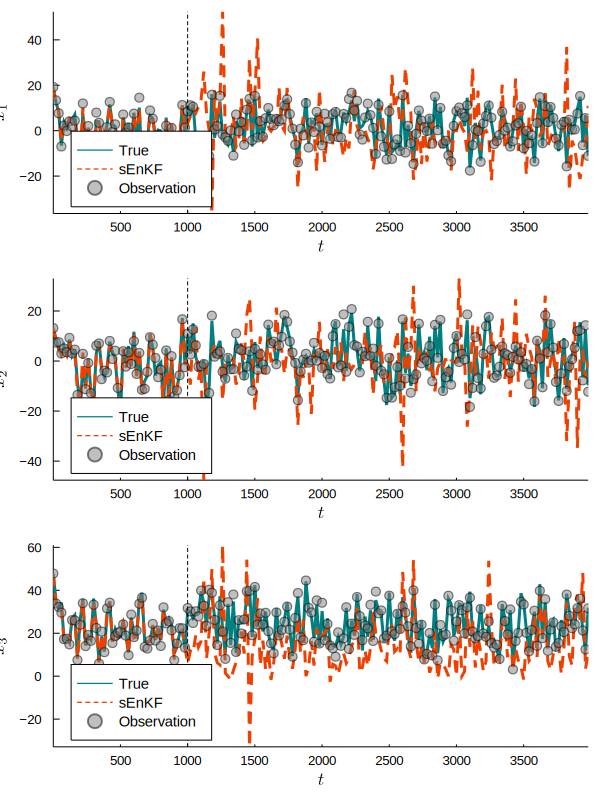

In [132]:
nb = 1
ne = Tspin+Tsmf
Δ = 50
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = :bottomleft, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(vcat(Xenkf[1:Tspin+1], Xsmf_greedy[2:end]))[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
    vline!(plt[i,1], [tspin], color = :grey2, linestyle = :dash, label = "")
end

plt